In [1]:
#%% -------- 1. Enhanced Configuration Cell --------
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os
import splitfolders
from torch.optim.lr_scheduler import OneCycleLR
import torchmetrics
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Hardware config
NUM_CLASSES = 4  # Binary classification
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 2
PRECISION = '16-mixed'
EPOCHS = 250
LR = 3e-5  # Increased learning rate
WARMUP_EPOCHS = 3
DATA_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brachial\\2nd Classification"
SPLIT_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brachial\\2nd Classification\\Split_Dataset"
SEED = 42

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED)

Seed set to 42


42

In [2]:
#%% -------- 2. Enhanced Data Preparation Cell --------
class_names = ['Type 0', 'Type 1 Neurapraxia', 'Type 2 Axonotemsis', 'Type 3 Nurotemesis']

def prepare_dataset():
    splitfolders.ratio(
        DATA_ROOT,
        output=SPLIT_ROOT,
        seed=SEED,
        ratio=(0.7, 0.15, 0.15),
        group_prefix=None,
        move=False
    )

if not os.path.exists(os.path.join(SPLIT_ROOT, 'train')):
    prepare_dataset()

# Enhanced MRI-specific transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Fixed normalization for 3 channels
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
train_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'val'), val_transform)
test_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'test'), val_transform)

# Class balancing with pos_weight
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)  # Add this line
pos_weight = torch.tensor([class_counts[0]/class_counts[1]], dtype=torch.float32)
samples_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

Copying files: 0 files [00:00, ? files/s]

Copying files: 970 files [00:02, 461.15 files/s]


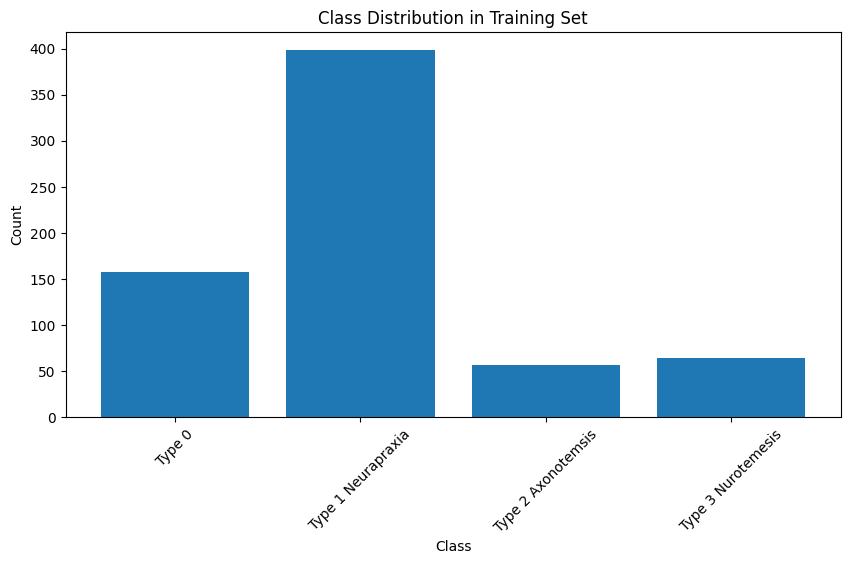

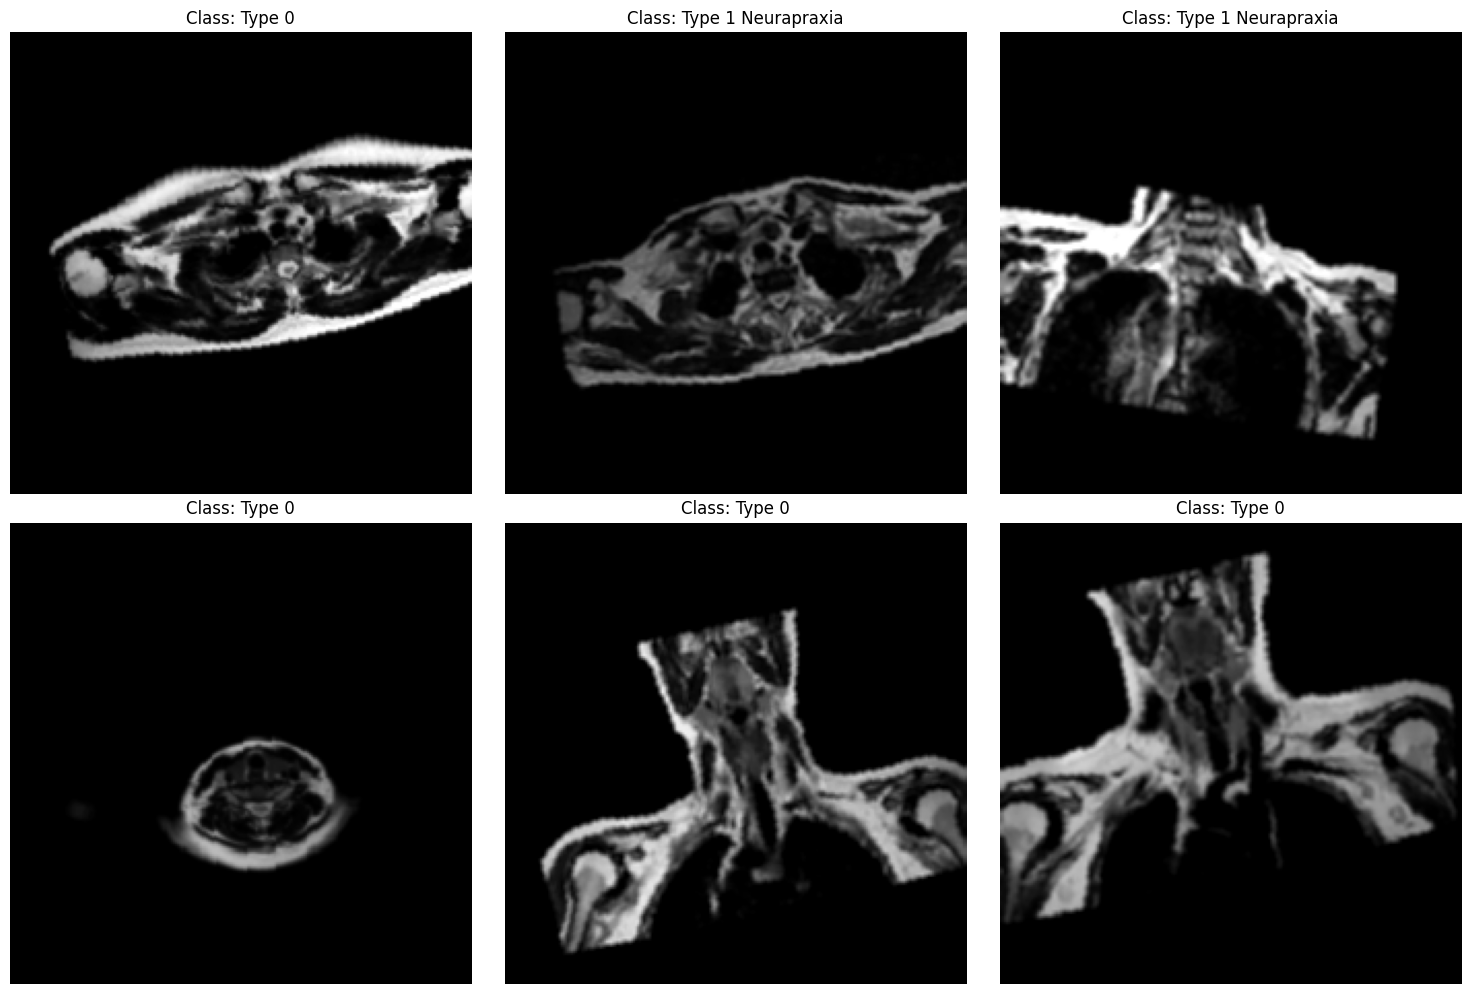

In [3]:
#%% -------- 3. Data Visualization Cell --------
class_names = ['Type 0', 'Type 1 Neurapraxia', 'Type 2 Axonotemsis', 'Type 3 Nurotemesis']

def plot_class_distribution():
    counts = np.bincount(train_dataset.targets)
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

def show_sample_images(dataset, num_images=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(2, 3, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f"Class: {class_names[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_distribution()
show_sample_images(train_dataset)

In [4]:
#%% -------- 4. Enhanced Model Definition Cell --------
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, 
                                            weight=self.alpha, 
                                            reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss
        return focal_loss.mean()

class BrachialPlexusResMT(nn.Module):
    def __init__(self, num_classes=4, img_size=224, patch_size=32, embed_dim=512, 
                 num_heads=8, num_layers=3, dropout=0.2):
        super().__init__()
        
        # ResNet-50 Backbone with partial unfreezing
        self.cnn_backbone = models.resnet50(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(self.cnn_backbone.children())[:-2])
        
        # Freeze initial layers
        for param in self.cnn_backbone.parameters():
            param.requires_grad = False
            
        # Unfreeze last residual block
        for param in self.cnn_backbone[-1].parameters():  # Layer4
            param.requires_grad = True

        # Feature adaptation
        self.feature_adapt = nn.Sequential(
            nn.Conv2d(2048, embed_dim, 1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU()
        )
        
        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(49, 1, embed_dim))
        
        # Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            embed_dim, num_heads, dim_feedforward=2048, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        
        # Enhanced Classifier with dropout
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(0.5),
            nn.Linear(embed_dim, num_classes)  # Output 4 classes
        )

    def forward(self, x):
        x = self.cnn_backbone(x)
        x = self.feature_adapt(x)
        x = x.flatten(2).permute(2, 0, 1)
        x = x + self.positional_encoding
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        return self.classifier(x)

In [5]:
#%% -------- 5. Enhanced Training Setup Cell --------
class LitModel(pl.LightningModule):
    def __init__(self, total_steps):
        super().__init__()
        self.save_hyperparameters()
        self.model = BrachialPlexusResMT(num_classes=NUM_CLASSES)
        self.class_weights = class_weights  # From data preparation
        self.criterion = FocalLoss(alpha=self.class_weights, gamma=2)
        
        # Updated metrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.train_auc = torchmetrics.AUROC(task='multiclass', num_classes=NUM_CLASSES)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.val_auc = torchmetrics.AUROC(task='multiclass', num_classes=NUM_CLASSES)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)  # y is class indices
        
        probs = torch.softmax(logits, dim=1)
        self.train_acc(probs, y)
        self.train_auc(probs, y)
        
        self.log_dict({'train_loss': loss, 'train_acc': self.train_acc, 'train_auc': self.train_auc},
                     prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        probs = torch.softmax(logits, dim=1)
        self.val_acc(probs, y)
        self.val_auc(probs, y)
        
        self.log_dict({'val_loss': loss, 'val_acc': self.val_acc, 'val_auc': self.val_auc},
                     prog_bar=True)
        return loss

    def configure_optimizers(self):
        # Differential learning rates
        backbone_params = []
        new_params = []
        for name, param in self.named_parameters():
            if 'cnn_backbone.layer4' in name:
                backbone_params.append(param)
            else:
                new_params.append(param)
        
        optimizer = optim.AdamW(
            [
                {'params': backbone_params, 'lr': LR/10},
                {'params': new_params, 'lr': LR}
            ],
            weight_decay=0.01
        )
        
        scheduler = OneCycleLR(
            optimizer,
            max_lr=[LR/10, LR],
            total_steps=self.hparams.total_steps
        )
        return [optimizer], [scheduler]

# Initialize
train_loader = DataLoader(train_dataset, BATCH_SIZE, sampler=sampler, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, num_workers=NUM_WORKERS,
                       pin_memory=True)
model = LitModel(total_steps=EPOCHS*len(train_loader))

# Callbacks
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_auc',
    mode='max',
    filename='best-{epoch}-{val_auc:.3f}',
    save_top_k=2
)

early_stop = pl.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=25,  # Increased patience
    mode='max',
    min_delta=0.001
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=EPOCHS,
    precision=PRECISION,
    callbacks=[checkpoint, early_stop],
    accumulate_grad_batches=4,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    deterministic="warn"
)

c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Program Files\Python311\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
C:\Users\DELL 5540\AppData\Roaming\Pyt

In [6]:
#%% -------- 6. Training Execution Cell --------
trainer.fit(model, train_loader, val_loader)
best_model = LitModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | model     | BrachialPlexusResMT | 34.0 M
1 | criterion | FocalLoss           | 0     
2 | train_acc | MulticlassAccuracy  | 0     
3 | train_auc | MulticlassAUROC     | 0     
4 | val_acc   | MulticlassAccuracy  | 0     
5 | val_auc   | MulticlassAUROC     | 0     
--------------------------------------------------
25.5 M    Trainable params
8.5 M     Non-trainable params
34.0 M    Total params
136.174   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


NotImplementedError: Module [LitModel] is missing the required "forward" function

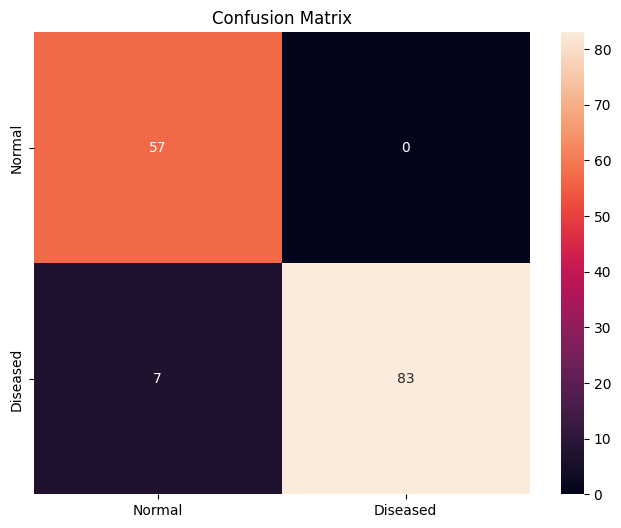

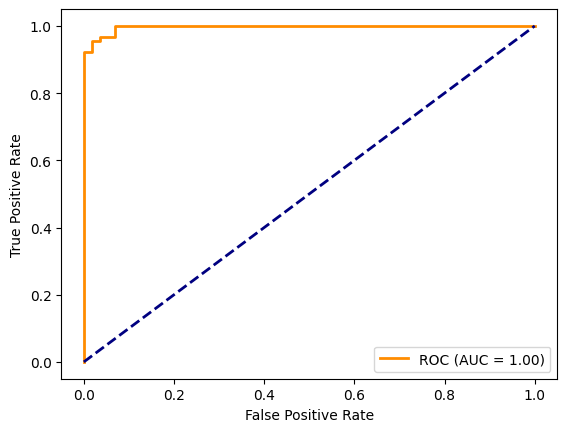

              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94        57
    Diseased       1.00      0.92      0.96        90

    accuracy                           0.95       147
   macro avg       0.95      0.96      0.95       147
weighted avg       0.96      0.95      0.95       147



In [ ]:
#%% -------- 7. Enhanced Evaluation with TTA --------
def evaluate():
    best_model.eval()
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(best_model.device), y.to(best_model.device)
            
            # TTA
            logits = best_model(x)
            logits_flipped = best_model(torch.flip(x, [3]))
            avg_logits = (logits + logits_flipped) / 2
            
            probs = torch.softmax(avg_logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    # Multi-class metrics
    print(classification_report(all_targets, all_preds, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    print(classification_report(all_targets, all_preds, target_names=class_names))

evaluate()

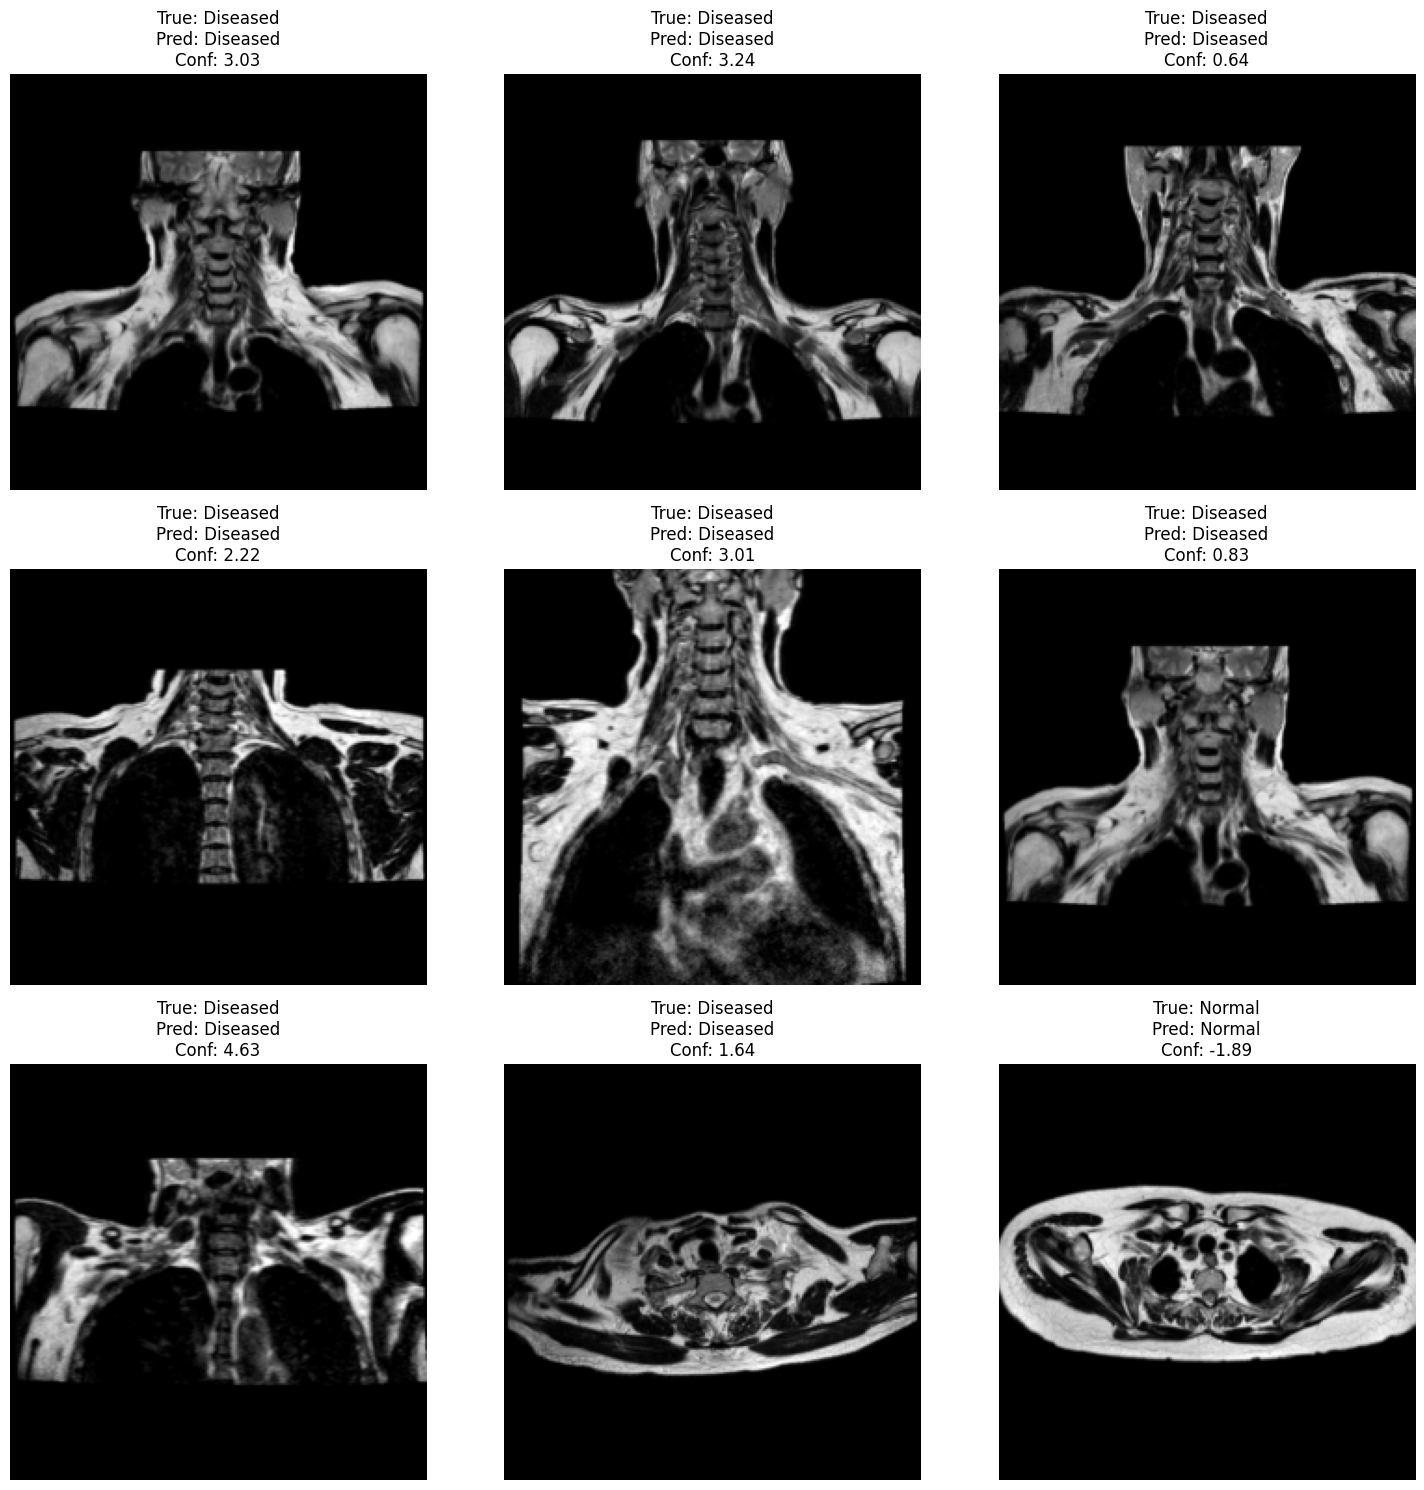

Full pipeline execution completed!


In [ ]:
#%% -------- 9. Inference Visualization Cell --------
def predict_and_visualize(model, dataset, num_images=9):
    model.eval()
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, true_label = dataset[idx]
        img_tensor = img.unsqueeze(0).to(model.device)
        
        with torch.no_grad():
            logits = model(img_tensor)
            probs = torch.softmax(logits, dim=1)
            conf, pred_label = torch.max(probs, dim=1)
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label.item()]}\nConf: {conf.item():.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()